# Прогнозирование оттока клиентов телекомуникационной компании

**Цель:**

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах. Необходимо на предоставленных данных обучить модель машинного обучения для прогнозирования ухода клиента.

**Описание данных:**

Оператор предоставляет два основных типа услуг: 
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Данные состоят из файлов, полученных из разных источников:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.



## План работы

1. Загрузить и изучить полученные данные. Сформировать вывод.
2. Провести предобработку и исследовательский анализ данных. Выделить\создать целевой признак. Сформировать вывод.
3. Подготовить признаки. Добавить новые признаки, удалить ненужные. Разделить итоговый датасет на тренировочную и тестовую выборки. Сформировать вывод.
4. Сравнить модели машинного обучения, подходящие для исследования, провести подбор гиперпараметров. Сформировать вывод.
5. Выявить лучшую модель и проверить ее эффективность на тестовых данных. Сформировать вывод.
6. Провести анализ важности признаков лучшей модели и анализ матрицы ошибок. Сформировать вывод.
7. Сформировать общий вывод.

## Загрузка и изучение данных

Импорт библиотек:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import phik
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, make_scorer, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

Загрузка данных:

In [2]:
pth_1_contract = 'contract_new.csv'
pth_2_contract = '/datasets/contract_new.csv'

if os.path.exists(pth_1_contract):
    df_contract = pd.read_csv(pth_1_contract)
elif os.path.exists(pth_2_contract):
    df_contract = pd.read_csv(pth_2_contract)
else:
    print('Something is wrong')

pth_1_internet = 'internet_new.csv'
pth_2_internet = '/datasets/internet_new.csv'

if os.path.exists(pth_1_internet):
    df_internet = pd.read_csv(pth_1_internet)
elif os.path.exists(pth_2_internet):
    df_internet = pd.read_csv(pth_2_internet)
else:
    print('Something is wrong')

pth_1_personal = 'personal_new.csv'
pth_2_personal = '/datasets/personal_new.csv'

if os.path.exists(pth_1_personal):
    df_personal = pd.read_csv(pth_1_personal)
elif os.path.exists(pth_2_personal):
    df_personal = pd.read_csv(pth_2_personal)
else:
    print('Something is wrong')

pth_1_phone = 'phone_new.csv'
pth_2_phone = '/datasets/phone_new.csv'

if os.path.exists(pth_1_phone):
    df_phone = pd.read_csv(pth_1_phone)
elif os.path.exists(pth_2_phone):
    df_phone = pd.read_csv(pth_2_phone)
else:
    print('Something is wrong')


### Информация о договорах (df_contract)

In [3]:
df_contract.head(20)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


In [4]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
df_contract.duplicated().sum()

0

Явных пропусков и дубликатов нет, необходима замена типов данных. Рассмотрим столбцы подробнее.

- `customerID` – содержит уникальный айди клиента;

- `BeginDate` – дата начала пользования услугами, поле необходимо привести к типу **datetime**;

- `EndDate` – дата окончания пользования услугами. Это целевой признак, любая дата в этом поле соответствует оттоку клиента, если стоит значение "No" - клиент остался. Однако, сама по себе дата несет в себе важную ифнормацию - длительность пользования клиентом услугами компании. Отсюда можно сгенерировать дополнительный признак для модели. Для значения "No" можно установить уникальную дату (например дату актуальности датасета - 2020-02-01), после чего привести поле к формату **datetime**;

- `Type` – тип оплаты, принимает три значения: ежемесячный, годовой, двухгодовой;

- `PaperlessBilling` – безналичный расчет, является бинарным признаком;

- `PaymentMethod` - способ оплаты, принимает четыре значения: электронный чек, почтовый чек, банковский перевод и кредитная карта;

- `MonthlyCharges` - ежемесячные траты на услуги, можно привести поле к целочисленному типу для экономии памяти;

- `TotalCharges` - всего потрачено денег на услуги, необходимо привести к числовому формату и заполнить неявные пропуски нулями.

### Информация об интернет-услугах (df_internet)

In [6]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [7]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [8]:
df_internet.duplicated().sum()

0

Явных пропусков и дубликатов нет, необходима замена типов данных. Рассмотрим столбцы подробнее.

- `customerID` – содержит уникальный айди клиента;

- `InternetService` - тип подключения. Может быть двух типов: через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic). Является бинарным признаком;

- `OnlineSecurity` - услуга блокировки небезопасных сайтов. Является бинарным признаком;

- `OnlineBackup` - услуга облачного хранилища файлов для резервного копирования данных. Является бинарным признаком;

- `DeviceProtection ` - услуга антивируса. Является бинарным признаком;

- `TechSupport` - выделенная линия технической поддержки. Является бинарным признаком;

- `StreamingTV` - услуга стримингового телевидения. Является бинарным признаком;

- `StreamingMovies` - услуга каталога фильмов. Является бинарным признаком.

### Информация о персональных данных клиентов (df_personal)

In [9]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [10]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [11]:
df_personal.duplicated().sum()

0

Явных пропусков и дубликатов нет, необходима замена типов данных. Рассмотрим столбцы подробнее.

- `customerID` – содержит уникальный айди клиента;

- `gender` - пол пользователя. Является бинарным признаком;

- `SeniorCitizen` - наличие пенсионного статуса по возрасту. Является бинарным признаком;

- `Partner` - наличие супруга(и). Является бинарным признаком;

- `Dependents` - наличие иждивенцев. Является бинарным признаком.

### Информация о телефонии (df_phone)

In [12]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [13]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [14]:
df_phone.duplicated().sum()

0

Явных пропусков и дубликатов нет, необходима замена типов данных. Рассмотрим столбцы подробнее.

- `customerID` – содержит уникальный айди клиента;

- `MultipleLines` - возможность подключения телефонного аппарата к нескольким линиям одновременно. Является бинарным признаком.

**Вывод:**

1. Загружены и рассмотрены таблицы с данными.

2. Всего в выборке представлены договоры с 7043 клиентами, из которых пользователей интернета - 5517, пользователей телефона - 6361.

3. Явные пропуски и дубликаты не найдены.

4. Проблемы для предобработки данных:

`BeginDate` – поле необходимо привести к типу datetime;

`EndDate` – это целевой признак, любая дата в этом поле соответствует оттоку клиента, если стоит значение "No" - клиент остался. Однако, сама по себе дата несет в себе важную ифнормацию - длительность пользования клиентом услугами компании. Отсюда можно сгенерировать дополнительный признак для модели. Для значения "No" можно установить уникальную дату (например дату актуальности датасета - 2020-02-01), после чего привести поле к формату datetime;

`MonthlyCharges` - можно привести поле к целочисленному типу для экономии памяти (два знака после запятой - излишняя точность в значениях);

`TotalCharges` - необходимо избавится от неявных пропусков (пустые значения, заполним нулями), а также привести к числовому формату, например целочисленный тип.

5. После этого следует объединить все данные в одну таблицу, провести исследовательский анализ данных, а также дополнительное исследование на наличие пропусков и аномалий.

## Предобработка и исследовательский анализ данных

Заполним неявные пропуски в поле `TotalCharges` нулями:

In [15]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].replace([' '], 0)

Приведем поле `BeginDate` к типу *datetime*, а `MonthlyCharges` и `TotalCharges` к целочисленному (*int*):

In [16]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'],format = '%Y-%m-%d')

df_contract['MonthlyCharges'] = df_contract['MonthlyCharges'].astype('int')

In [17]:
#Так как строковое значение с точкой невозможно сразу преобразовать в целочисленный тип,
#поле TotalCharges сначала приводится в вещественный (float), и потом в целый (int).
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype('float')
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype('int')

Приведем поле `SeniorCitizen` к типу *object* как и остальные категориальные признаки.

In [18]:
df_personal['SeniorCitizen'] = df_personal['SeniorCitizen'].replace(0, 'No')
df_personal['SeniorCitizen'] = df_personal['SeniorCitizen'].replace(1, 'Yes')

Предобработка датафреймf `df_contract` завершена. Выполним объединение данных в одну таблицу для дальнейшей предобработки в остальных датафреймах:

In [19]:
df_telecom = df_contract.set_index('customerID').join(df_phone.set_index('customerID'))
df_telecom = df_telecom.join(df_personal.set_index('customerID'))
df_telecom = df_telecom.join(df_internet.set_index('customerID'))

In [20]:
df_telecom.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29,31,NaN,Female,No,Yes,No,DSL,No,Yes,No,No,No,No
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56,2071,No,Male,No,No,No,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53,226,No,Male,No,No,No,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42,1960,NaN,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70,353,No,Female,No,No,No,Fiber optic,No,No,No,No,No,No


Выведем информацию о новом датафрейме.

In [21]:
df_telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   int32         
 6   TotalCharges      7043 non-null   int32         
 7   MultipleLines     6361 non-null   object        
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   object        
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup  

Так как не все пользователи пользуются всеми услугами, которые предоставляет оператор связи, возникли пропуски. Позже заполним их значением соответствующим "NoUsed".

Выделим целевой признак и проверим баланс его классов.

In [22]:
df_telecom['escape_client'] = (df_telecom['EndDate'] != "No") * 1
df_telecom['escape_client'].value_counts(normalize=True)

0    0.843675
1    0.156325
Name: escape_client, dtype: float64

Присутствует дисбаланс классов (84/16).

Поставим "заглушку" в поле `EndDate` (дату актуальности датасета - 2020-02-01) и приведем к типу *datetime* для будущих вычислений.

In [23]:
df_telecom['EndDate'] = df_telecom['EndDate'].replace(['No'], ['2020-02-01'])
df_telecom['EndDate'] = pd.to_datetime(df_telecom['EndDate'],format = '%Y-%m-%d')

In [24]:
# здесь и далее - размер всех графиков
plt.rcParams["figure.figsize"] = (12,7)

Рассмотрим распределение ежемесячных трат пользователей.

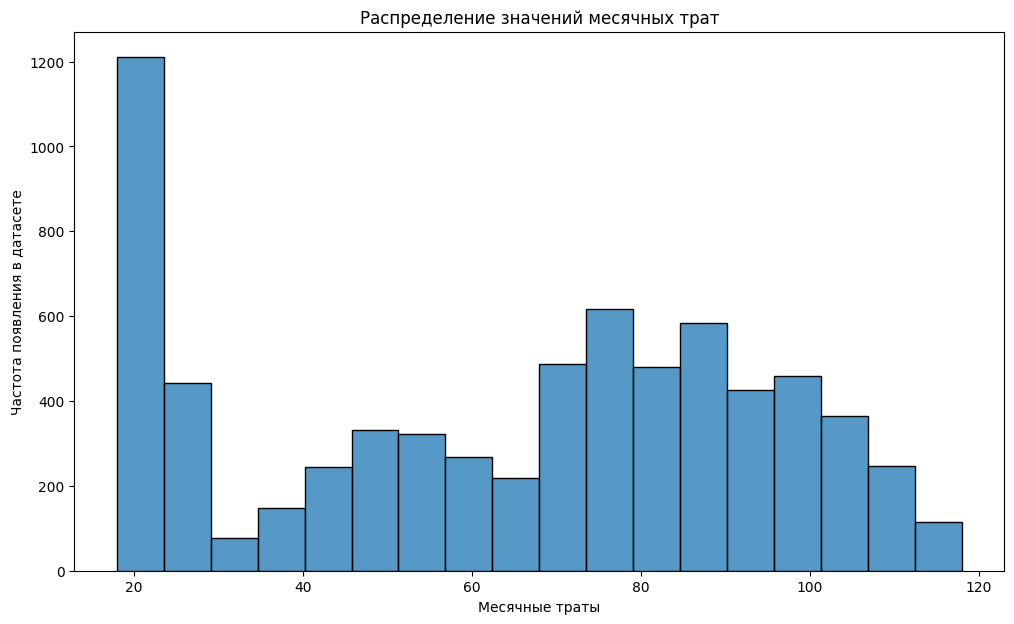

In [25]:
sns.histplot(df_telecom['MonthlyCharges'])
plt.title('Распределение значений месячных трат')
plt.xlabel('Месячные траты')
plt.ylabel('Частота появления в датасете');

По распределению значений месячных трат выделяются три основные группы клиентов:

- с месячными тратами со значениями 20-30;
- с месячными тратами со значениями 30-70;
- с месячными тратами со значениями 70-120.

Рассмотрим распределение значений суммарных трат.

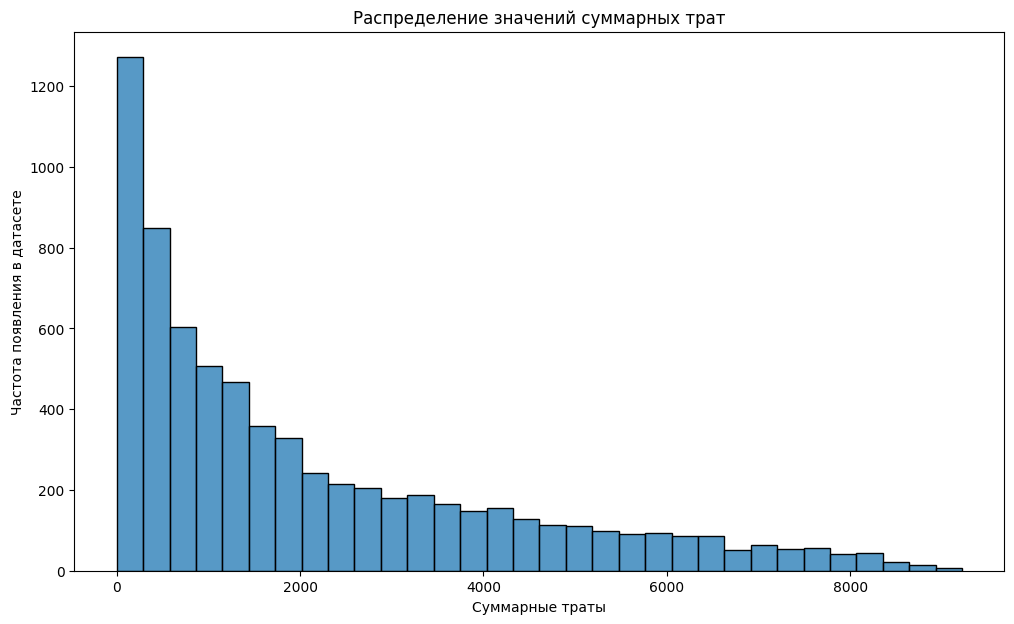

In [26]:
sns.histplot(df_telecom['TotalCharges'])
plt.title('Распределение значений суммарных трат')
plt.xlabel('Суммарные траты')
plt.ylabel('Частота появления в датасете');

В распределении есть неявные пропуски, попробуем выяснить их природу.

In [27]:
df_telecom.loc[df_telecom['TotalCharges'] == 0]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,escape_client
customerID,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52,0,NaN,Female,No,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20,0,No,Male,No,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80,0,No,Female,No,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25,0,Yes,Male,No,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56,0,NaN,Female,No,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19,0,No,Male,No,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25,0,Yes,Male,No,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20,0,No,Female,No,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19,0,No,Male,No,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


Это клиенты, начавшие пользоваться услугами в феврале 2020 года, в этом случае суммарные траты равны месячным (дата актуальности датасета - 2020-02-01):

In [28]:
df_telecom.loc[df_telecom['TotalCharges'] == 0, 'TotalCharges'] = df_telecom['MonthlyCharges']

Изучим подробнее дату регистрации клиентов.

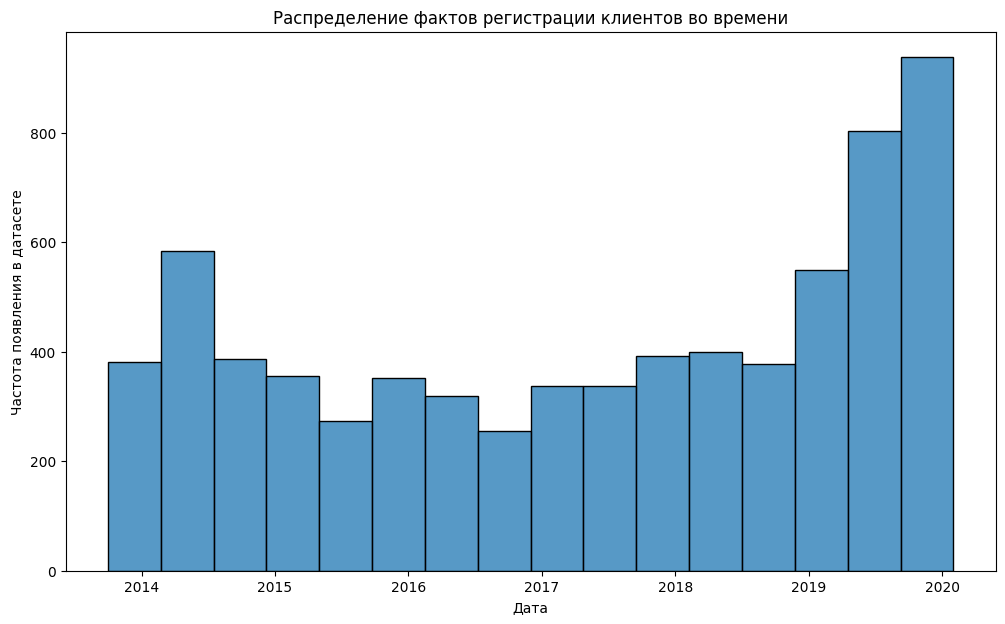

In [29]:
sns.histplot(df_telecom['BeginDate'])
plt.title('Распределение фактов регистрации клиентов во времени')
plt.xlabel('Дата')
plt.ylabel('Частота появления в датасете');

Наблюдается пик в начале 2014 года, что связано с началом работы компании. С начала 2015 по конец 2018 года - величина новых клиентов стабильна. С начала 2019 по начало 2020 года снова наблюдается бурный рост количества новых клиентов.

Рассмотрим распределение оттока клиентов во времени.

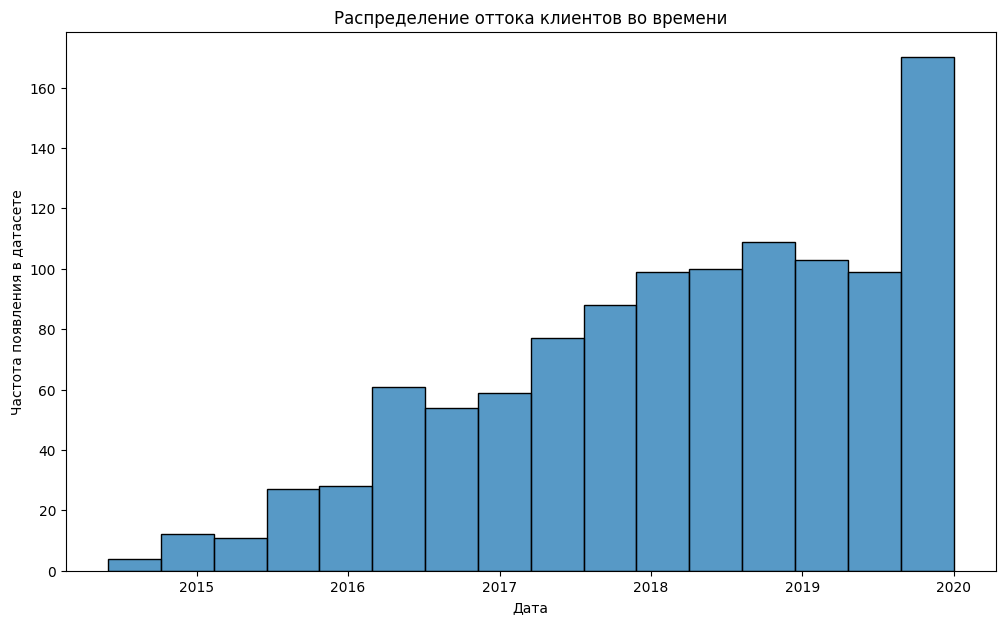

In [30]:
sns.histplot(df_telecom[df_telecom['EndDate'] != '2020-02-01']['EndDate'])
plt.title('Распределение оттока клиентов во времени')
plt.xlabel('Дата')
plt.ylabel('Частота появления в датасете');

Как видно на графике, начиная с 2016 года число ушедших пользователей значительно увеличилось с начала работы компании. Начиная с 2017 года это число держится примерно на одном уровне. Начало 2020 года можно не рассматрвать, так как в датафрейме у всех действующих пользователей в столбце `EndDate` записана дата акктуальности датасета (2020-02-01).

#### Анализ категориальных признаков

Type:
Month-to-month - 55.01916796819537
One year - 20.914383075394007
Two year - 24.06644895641062
--------------------------------------------------
PaperlessBilling:
Yes - 59.22192247621752
No - 40.77807752378248


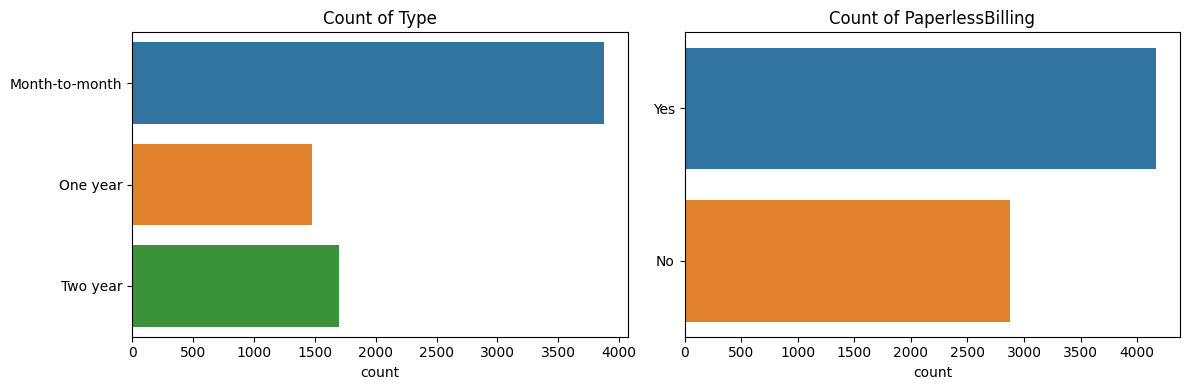

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
PaymentMethod:
Electronic check - 33.57944057929859
Mailed check - 22.887973874769273
Bank transfer (automatic) - 21.92247621752094
Credit card (automatic) - 21.610109328411188
--------------------------------------------------
MultipleLines:
nan - 0.0
No - 53.29350731017136
Yes - 46.70649268982864


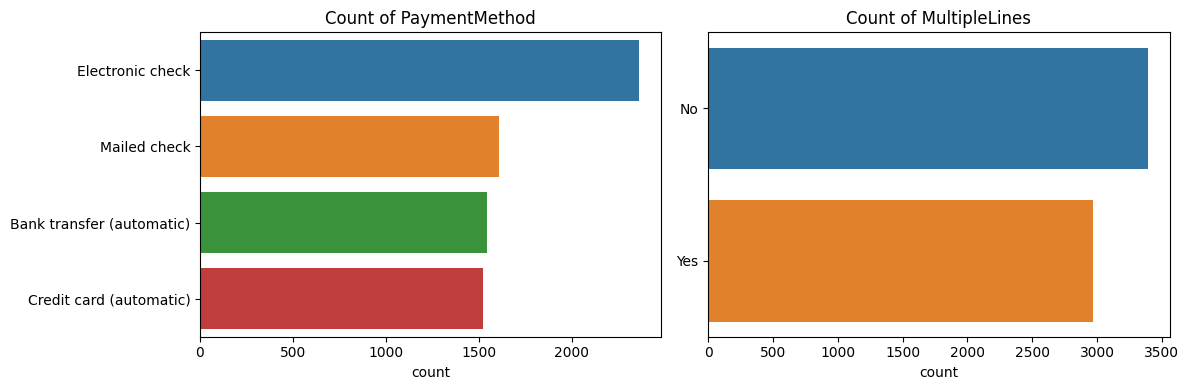

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
gender:
Female - 49.524350418855605
Male - 50.475649581144395
--------------------------------------------------
SeniorCitizen:
No - 83.78531875621184
Yes - 16.21468124378816


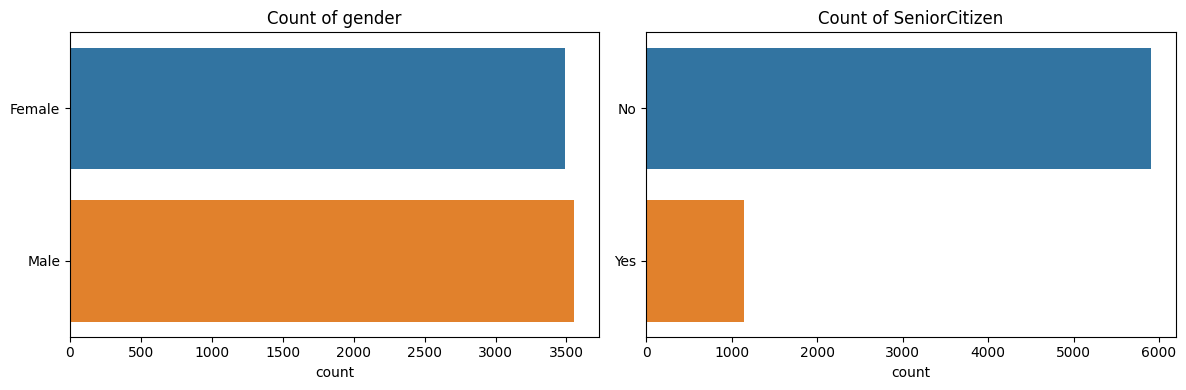

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Partner:
Yes - 48.30327985233565
No - 51.69672014766435
--------------------------------------------------
Dependents:
No - 70.04117563538264
Yes - 29.95882436461735


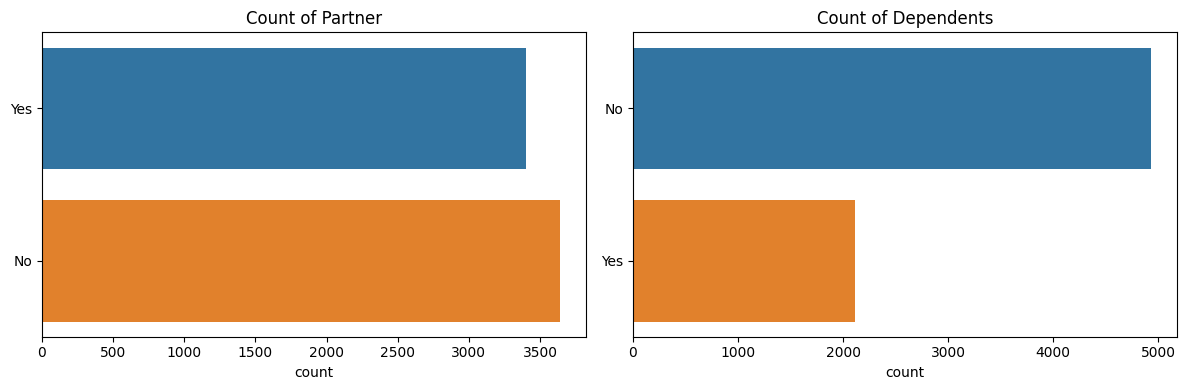

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
InternetService:
DSL - 43.882544861337685
Fiber optic - 56.117455138662315
nan - 0.0
--------------------------------------------------
OnlineSecurity:
No - 63.40402392604676
Yes - 36.59597607395324
nan - 0.0


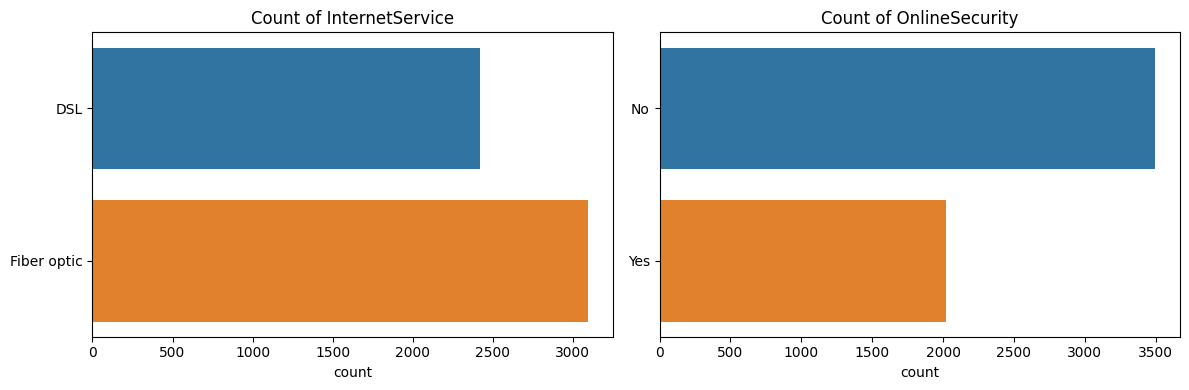

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
OnlineBackup:
Yes - 44.027551205365235
No - 55.972448794634765
nan - 0.0
--------------------------------------------------
DeviceProtection:
No - 56.09932934565887
Yes - 43.90067065434113
nan - 0.0


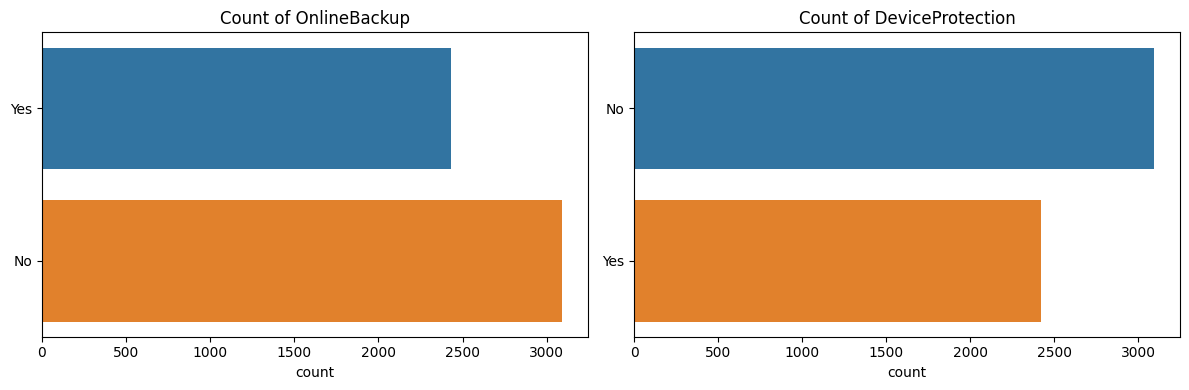

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
TechSupport:
No - 62.95087910096067
Yes - 37.04912089903933
nan - 0.0
--------------------------------------------------
StreamingTV:
No - 50.93347833967736
Yes - 49.06652166032264
nan - 0.0


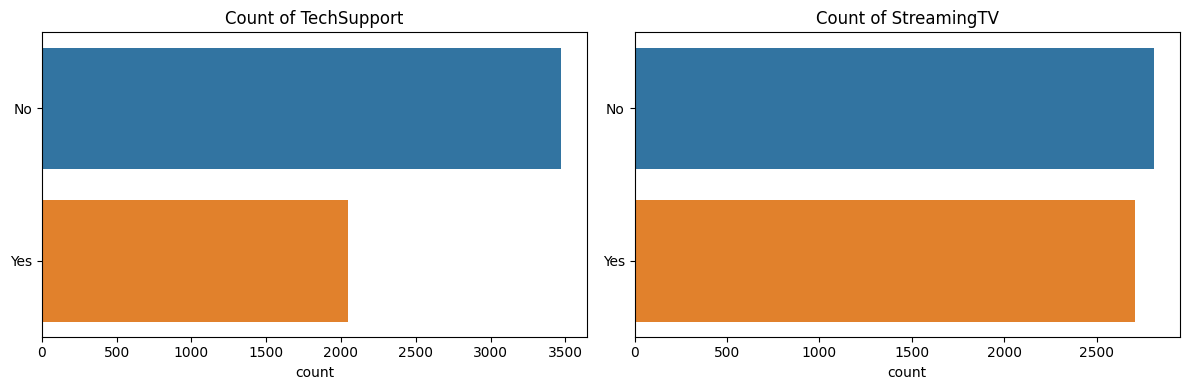

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
StreamingMovies:
No - 50.480333514591265
Yes - 49.519666485408735
nan - 0.0
--------------------------------------------------
escape_client:
0 - 84.36745704955274
1 - 15.632542950447252


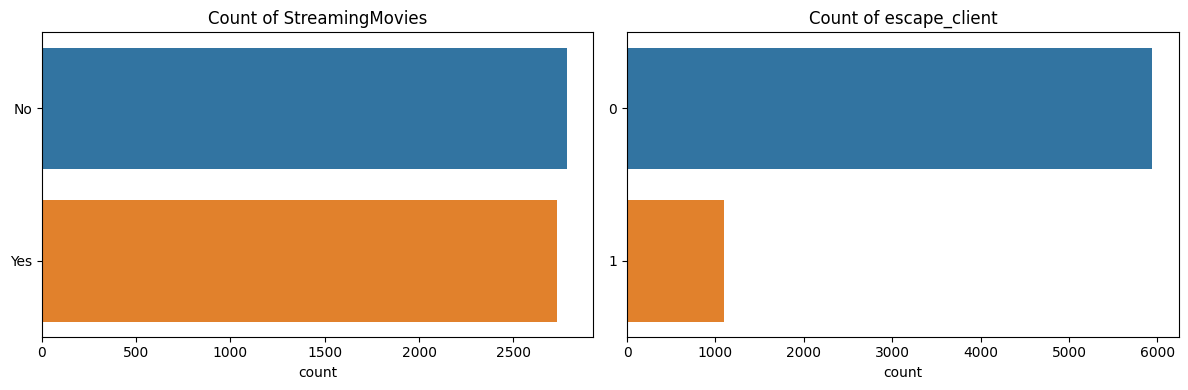

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [31]:
def percent_of_total_amount(df, column):
    parts_column = len(df[column].unique())
    len_all_column = df[column].count()
    for i in range(parts_column):
        uniqu_column = df[column].unique()[i]
        print(uniqu_column, '-', (len(df[df[column] == uniqu_column])*100)/len_all_column)

cat_col = list(filter(lambda a: a not in ['MonthlyCharges',
                                          'TotalCharges',
                                          'BeginDate',
                                          'EndDate'] , df_telecom.columns))

for i in range(0, len(cat_col)-1, 2):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].set_title(f'Count of {cat_col[i]}')
    print(f'{cat_col[i]}:')
    percent_of_total_amount(df_telecom, cat_col[i])
    print('-'*50)
    ax[1].set_title(f'Count of {cat_col[i+1]}')
    print(f'{cat_col[i+1]}:')
    percent_of_total_amount(df_telecom, cat_col[i+1])

    sns.countplot(data = df_telecom, y = df_telecom[cat_col[i]], ax=ax[0])
    sns.countplot(data = df_telecom, y = df_telecom[cat_col[i+1]], ax=ax[1])

    ax[0].set_ylabel('')
    ax[1].set_ylabel('')
    fig.tight_layout()


    plt.show()
    print('-'*200)

Из категориальных характеристик объедененного датафрейма можно выделить следующее:

- 59% пользователей предпочитают безналичный расчет;

- 16% пользователей - пенсионеров, 48% - имеют супруга(у), у 30% - имеются иждевенцы. Виден баланс классов гендера;

- 44% пользователей используют интернет соединение через телефонную линию, 47% пользователей имеют возможность подключения телефонного аппарата к нескольким линиям одновременно;

- Данные по услугам:

|Услуга|Процент пользователей|
|:-|:-|
|Блокировка небезопасных сайтов (OnlineSecurity)|36%|
|Облачное хранилище файлов для резервного копирования данных (OnlineBackup)|44%|
|Антивирус (DeviceProtection)|45%|
|Выделенная линия технической поддержки (TechSupport)|37%|
|Стриминговое телевидение (StreamingTV)|49%|
|Каталог фильмов (StreamingMovies)|49%|

Создадим признак соответствующий длительности пользования клиентом услугами компании.

In [32]:
df_telecom['TotalTime'] = (df_telecom['EndDate'] - df_telecom['BeginDate']).dt.days

In [33]:
df_telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   int32         
 6   TotalCharges      7043 non-null   int32         
 7   MultipleLines     6361 non-null   object        
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   object        
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup  

Рассмотрим тепловую карту корреляции признаков.

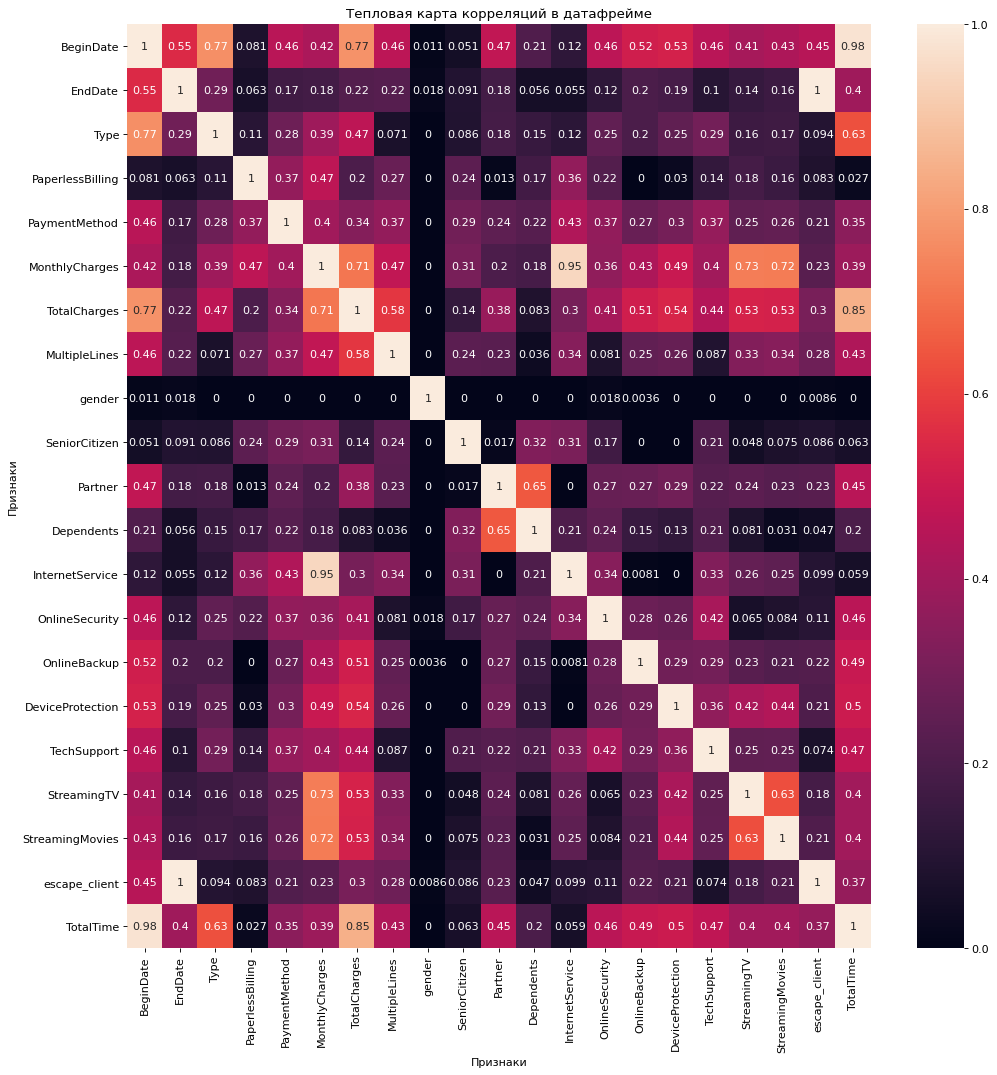

In [34]:
plt.figure(figsize=(15, 15), dpi= 80)
hm = sns.heatmap(data=df_telecom.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'escape_client', 'TotalTime']), annot=True)
plt.title("Тепловая карта корреляций в датафрейме")
plt.xlabel("Признаки")
plt.ylabel("Признаки")
plt.show();

Имеется следующие высокие значения корреляции:

- `MonthlyCharges` и `InternetService` (0.95);
- `TotalCharges` и `TotalTime` (0.85).

Необходимо избавиться от такой мультиколлинеарности, удалим те признаки, которые меньше всего коррелируют целевым признаком. Это будут признаки `InternetService` и `TotalCharges`.

Так же корреляция около нуля со значением пола, этот признак тоже удалим.

Уберем строчку со значением пола.

In [35]:
df_telecom = df_telecom.drop(['gender', 'InternetService', 'TotalCharges'], axis=1)

#### Подготовка данных для моделей

Зафиксируем `random_state` для моделей.

In [36]:
STATE = 140823

Удалим признаки с датами.

In [37]:
df_telecom = df_telecom.drop(['BeginDate', 'EndDate'], axis=1)

In [38]:
df_telecom.shape

(7043, 16)

Выделим целевой признак.

In [39]:
target = df_telecom['escape_client']

И остальные признаки.

In [40]:
features = df_telecom.drop('escape_client', axis=1)

Произведем деление на обучающую и тестовую выборки (соотношение 3:1).

In [41]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                             target,
                                                                             train_size=.75,
                                                                             random_state=STATE)

In [42]:
print(f'Размер обучающей выборки: features - {features_train.shape}, target - {target_train.shape}')
print(f'Размер тестовой выборки: features - {features_test.shape}, target - {target_test.shape}')

Размер обучающей выборки: features - (5282, 15), target - (5282,)
Размер тестовой выборки: features - (1761, 15), target - (1761,)


#### Кодрование признаков

In [43]:
#Закодируем признаки типа `object` для модели дерева решений и градиентного спуска.
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)

In [44]:
tree_columns = df_telecom.select_dtypes(include=['object']).columns
encoder.fit(features_train[tree_columns])

features_train_ord = features_train.copy()
features_test_ord = features_test.copy()

features_train_ord[tree_columns] = encoder.transform(features_train_ord[tree_columns])
features_test_ord[tree_columns] = encoder.transform(features_test_ord[tree_columns])

In [45]:
#Кодирование для линейной модели
ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')

In [46]:
ohe.fit(features_train[tree_columns])

def features_ohe(ohe_variable, df_features, features_categ):
    df_features_ohe = pd.DataFrame(
        data=ohe_variable.transform(df_features[features_categ]), 
        index=df_features.index,
        columns=ohe_variable.get_feature_names_out()
    )

    df_features = df_features.drop(features_categ, axis=1)
    df_features = df_features.join(df_features_ohe)
    return df_features    

features_train_ohe = features_ohe(ohe, features_train, tree_columns);
features_test_ohe = features_ohe(ohe, features_test, tree_columns);

#### Масштабирование

Проведем масштабирование признаков, так как в разных столбцах находятся значения с разными разбросами.

In [47]:
numeric = ['MonthlyCharges', 'TotalTime']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [48]:
features_train_ohe[numeric] = scaler.transform(features_train[numeric])
features_train_ohe.head()

,MonthlyCharges,TotalTime,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MultipleLines_Yes,MultipleLines_nan,...,OnlineBackup_Yes,OnlineBackup_nan,DeviceProtection_Yes,DeviceProtection_nan,TechSupport_Yes,TechSupport_nan,StreamingTV_Yes,StreamingTV_nan,StreamingMovies_Yes,StreamingMovies_nan
customerID,,,,,,,,,,,,,,,,,,,,,
2082-CEFLT,-0.638433,-1.101961,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5027-XWQHA,-0.671750,-0.919811,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6941-KXRRV,-0.205313,0.835053,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4716-MRVEN,-1.471355,-0.020906,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
8645-KWHJO,-0.305264,-0.696195,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [49]:
features_test_ohe[numeric] = scaler.transform(features_test[numeric])
features_test_ohe.head()

,MonthlyCharges,TotalTime,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MultipleLines_Yes,MultipleLines_nan,...,OnlineBackup_Yes,OnlineBackup_nan,DeviceProtection_Yes,DeviceProtection_nan,TechSupport_Yes,TechSupport_nan,StreamingTV_Yes,StreamingTV_nan,StreamingMovies_Yes,StreamingMovies_nan
customerID,,,,,,,,,,,,,,,,,,,,,
9554-DFKIC,-0.338581,0.025002,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4282-ACRXS,-1.338088,0.384860,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8792-AOROI,0.027905,-0.965719,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4403-BWPAY,-1.338088,-0.832438,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2898-MRKPI,1.227313,1.738400,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


**Вывод:**

Все поставленные задачи по предобработке данных выполнены:

1. В поле `EndDate` – установлена "заглушка", соответствующая дате актуальности датасета - 2020-02-01;
2. В поле `TotalCharges` неявные пропуски заполнены нулями;
3. Поля `BeginDate` и `EndDate` приведены к типу *datetime*, а `MonthlyCharges` и `TotalCharges` - к целочисленному (*int*).

После чего все датафреймы были объединены. Были заполнены пропуски, возникшие при объеднении датафреймов и закодированы строковые признаки.

---

Из категориальных характеристик объедененного датафрейма можно выделить следующее:

- 59% пользователей предпочитают безналичный расчет;

- 16% пользователей - пенсионеров, 48% - имеют супруга(у), у 30% - имеются иждевенцы. Виден баланс классов гендера;

- 44% пользователей используют интернет соединение через телефонную линию, 47% пользователей имеют возможность подключения телефонного аппарата к нескольким линиям одновременно;

- Данные по услугам:

|Услуга|Процент пользователей|
|:-|:-|
|Блокировка небезопасных сайтов (OnlineSecurity)|36%|
|Облачное хранилище файлов для резервного копирования данных (OnlineBackup)|44%|
|Антивирус (DeviceProtection)|45%|
|Выделенная линия технической поддержки (TechSupport)|37%|
|Стриминговое телевидение (StreamingTV)|49%|
|Каталог фильмов (StreamingMovies)|49%|

- Был выделен целевой признак ушел ли клиент или нет;

- Присутствует дисбаланс классов (84/16). На этапе подготовки данных для модели нужно рассмотреть эту проблему подробнее;

- По распределению значений месячных трат выделяются три основные группы клиентов:

    - с месячными тратами со значениями 20-30;
    - с месячными тратами со значениями 30-70;
    - с месячными тратами со значениями 70-120;

- Заполнены неявные пропуски суммарных трат у новых пользователей;

- Рассмотренны распределения оттока и прихода клентов;

- Создан признак длительности пользования клиентом услугами компании;

- Рассмотренна тепловая карта с корреляцией признаков. Удалены признаки с нулевой корреляцей и мультиколлинеарности;

- Данные подготовлены для обучения моделей.


### Выбор лучшей модели

Для обучения взяты следующие модели: логистическая регрессия (`LogisticRegression`), модель градиентного спуска (`CatBoost`) и модель дерева решений (`DecisionTree`).

Подберем гиперпараметры для каждой из моделей для дальнейшего анализа времени обучения, времени предсказания и качества модели.

#### Логистическая регрессия (`LogisticRegression`)

In [50]:
model_lr = LogisticRegression()
model_lr.fit(features_train_ohe, target_train)
lr_auc_roc = np.mean(cross_val_score(model_lr, features_train_ohe, target_train, cv=5, scoring=make_scorer(roc_auc_score, needs_proba=True)))
print(f'Best AUC_ROC: {lr_auc_roc:.2f}')

Best AUC_ROC: 0.75


#### Модель градиентного спуска (`CatBoost`)

In [51]:
catboost = CatBoostClassifier(random_state=STATE, verbose=False) 
hyperparams_cbc = [{'depth':[1,2,3,4,5],
                    'learning_rate':[0.1, 0.2, 0.3],
                    'iterations':[500,1000]}]
cbc = GridSearchCV(catboost, hyperparams_cbc, scoring='roc_auc')
cbc.fit(features_train_ord, target_train)
print(cbc.best_params_)
print(f'Best AUC_ROC: {cbc.best_score_:.3f}')

{'depth': 2, 'iterations': 1000, 'learning_rate': 0.3}
Best AUC_ROC: 0.929


#### Модель дерева решений (`DecisionTree`)

In [52]:
decisiontree = DecisionTreeClassifier(random_state=STATE)
max_depth_list = [None] + [x for x in range(2, 7)]
list_samples_split = [x for x in range(1, 10)]
list_samples_leaf = [x for x in range(1, 10)]

hyperparams_dtc = [{'max_depth':max_depth_list,
                    'min_samples_split':list_samples_split,
                    'min_samples_leaf':list_samples_leaf}]

dtc = GridSearchCV(decisiontree, hyperparams_dtc, scoring='roc_auc')
dtc.fit(features_train_ord, target_train)
print(dtc.best_params_)
print(f'Best AUC_ROC: {dtc.best_score_:.3f}')

{'max_depth': 6, 'min_samples_leaf': 9, 'min_samples_split': 2}
Best AUC_ROC: 0.721


Лучшей моделью является `CatBoostClassifier`, с метрикой roc_auc в 0.929. 

### Тестирование лучшей модели

In [53]:
best_model = CatBoostClassifier(depth=5,
                                iterations=1000,
                                learning_rate=0.3,
                                random_state=STATE,
                                verbose=False)
best_model.fit(features_train_ord, target_train)

Напишем функцию для построения ROC-кривой и матрицы ошибок для тестирования лучшей модел по итогам обучения.

In [54]:
def testing_model(features_test, target_test, model):
    plt.rcParams["figure.figsize"] = (12,7)
    predictions_test = model.predict(features_test)
    probabilities_test = model.predict_proba(features_test)[:,1]
    fpr, tpr, threshold = roc_curve(target_test, probabilities_test)
    
    roc_auc = roc_auc_score(target_test, probabilities_test)
    accuracy = accuracy_score(target_test, predictions_test)
    
    print('Класс модели: ', type(model).__name__)
    print('roc-auc: ', roc_auc)
    print('accuracy: ', accuracy)
    
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_test, pos_label=1)
    plt.plot(fpr, tpr, label=type(model).__name__)
    plt.xlabel('Вероятность ошибки 1-рода')
    plt.ylabel('Recall')
    plt.title('ROC-кривая модели класса ' + type(model).__name__)
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend();
    
    cmatrix = confusion_matrix(target_test, predictions_test)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cmatrix, 
                annot=True,  
                cmap='Blues', 
                fmt='d').set(title='Матрица ошибок', xlabel='Предсказания', ylabel='Правильные ответы')
    plt.show();

Класс модели:  CatBoostClassifier
roc-auc:  0.9282667410825518
accuracy:  0.9312890403180011


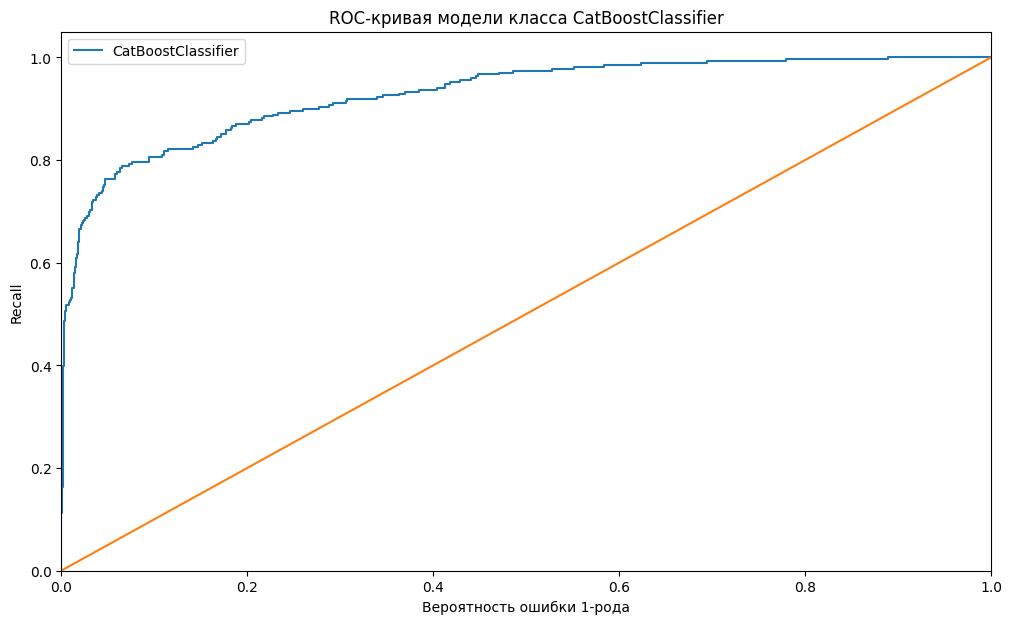

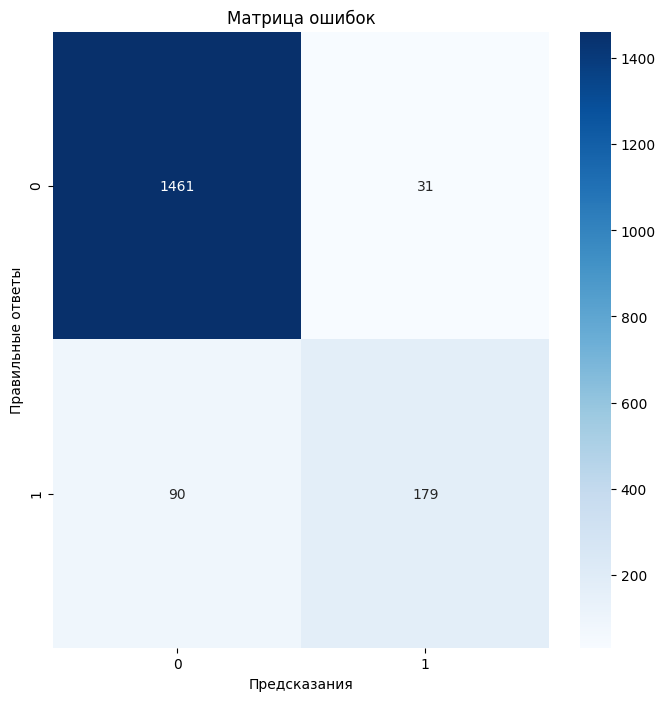

In [55]:
testing_model(features_test_ord, target_test, best_model)

На тестовых данных модель показала себя хорошо. Метрика AUC-ROC = 0.92, а accuracy = 0.93.

Метрика accuracy (точность) - это показатель, который позволяет измерить, насколько точно модель машинного обучения классифицирует данные. Он выражается в процентах и указывает долю правильных предсказаний модели относительно всех предсказаний.

Чтобы вычислить accuracy, сравнивается предсказанные значения модели с правильными ответами и определяется доля правильных предсказаний модели относительно общего числа предсказаний.

Например, предположим, у нас есть модель, которая классифицирует письма электронной почты на спам и не спам. Используем модель для классификации 100 писем, из которых 90 — не спам и 10 — спам. Если модель правильно классифицирует 88 из 90 не спам писем и 8 из 10 спам писем, то accuracy будет равняться:

(88 + 8) / 100 = 96%

То есть, в данном случае модель правильно предсказывает класс в 96 случаях из 100. 

Матрица ошибок является инструментом для оценки производительности модели классификации. Она представляет собой квадратную таблицу, где каждая ячейка представляет собой счетчик отнесенных экземпляров к определенному классу.

В матрице ошибок обычно присутствуют четыре основные метрики:

- True Positive (TP): Количество положительных случаев, которые успешно распознаны. В данном случае это те пользователи, которые действительно ушли.
- True Negative (TN): Количество отрицательных случаев, которые успешно распознаны. То есть те пользователи, которые продолжают пользоваться услугами.
- False Positive (FP): Количество случаев, когда неправильно классифицирован положительный случай. Модель машинного обучения предсказала, что пользователь уже ушел, но на сама деле он еще пользуется продуктами компании.
- False Negative (FN): Количество случаев, когда неправильно классифицирован отрицательный случай. Тут наоборот, пользователь уже ушел, но модель предсказала, что пользователь все еще пользуется услугами.


### Анализ важности признаков

In [56]:
train_dataset = Pool(features_train_ord, target_train)

In [57]:
feature_importance = best_model.get_feature_importance(train_dataset, prettified = True)

In [58]:
feature_importance

,Feature Id,Importances
0,TotalTime,44.535757
1,MonthlyCharges,15.309332
2,Type,6.517344
3,PaymentMethod,6.387834
4,Partner,4.425936
5,Dependents,3.197662
6,MultipleLines,3.145836
7,PaperlessBilling,3.032280
8,DeviceProtection,2.390501
9,TechSupport,2.208005


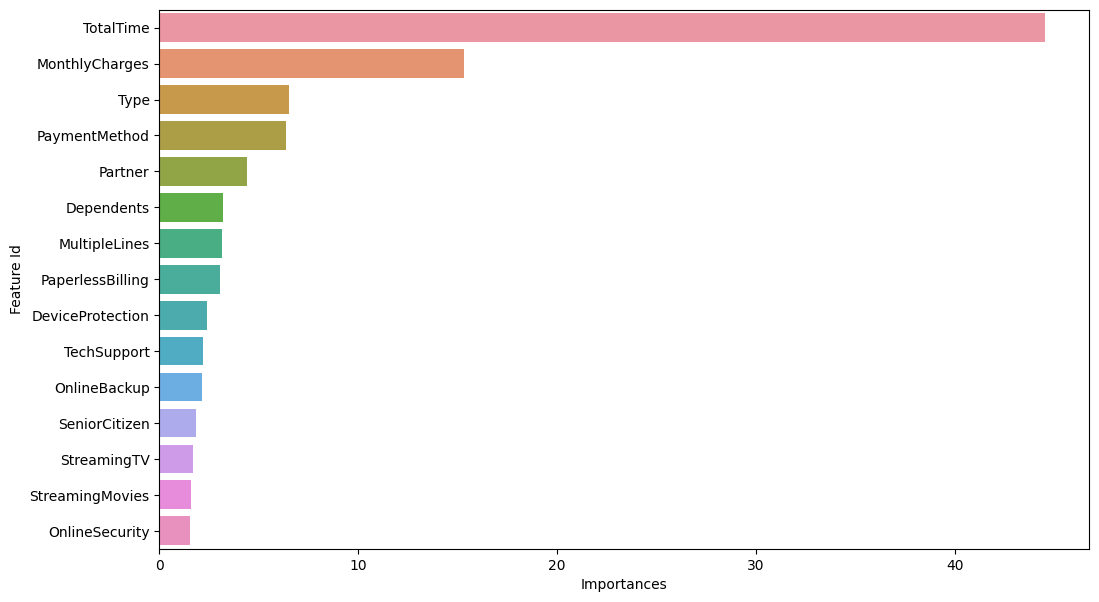

In [59]:
sns.barplot(y=feature_importance['Feature Id'], x=feature_importance['Importances']);

Логично, что на лояльность клиентов больше всего влияет время использования услуг. Чем дольше пользуются услугами компании, тем меньше вероятность что от туда уйдут. Второй и третий признак - месячные траты и тип подписки, соответственно. Это тоже достаточно логично, учитывая исследовательский анализ данных проведенных ранее.

### Общий вывод

Для оператора связи была обучена модель машинного обучения для прогнозирования оттока клиентов. Благодаря ей оператор связи сможет предлагать промокоды и специальные условия для тех клиентов, которые по прогнозу планируют уходить.

Для обучения модели машинного обучения были предоставленны персональные данные о некоторых клиентах, информацию об их тарифах и договорах. Информация о договорах актуальна на 1 февраля 2020.


Для оператора связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах. Необходимо на предоставленных данных обучить модель машинного обучения для прогнозирования ухода клиента.

**Ключевые шаги работы над проектом:**

1. Загрузка и изучение данных.

- Данные были загружены, изучены и рассмотрены таблицы с данными. Всего в выборке представлены договоры с 7043 клиентами, из которых пользователей интернета - 5517, пользователей телефонии - 6361. При изучении были выявлены проблемы с данными, которые были рассмотренны подробно и решены на этапе предобработки данных.
---
2. Предобработка и исследовательский анализ данных. Создание целевого признака.

- Проведены предобработка и исследовательский анализ данных. Проблемы, найденные на первом шаге работы над проектом были успешно решены. Данные были собраны в одну таблицу, после чего были решены проблемы после объединения. Был проведен анализ данных, из которого можно выделить следуюшее: 

    - 59% пользователей предпочитают безналичный расчет;

    - 16% пользователей - пенсионеров, 48% - имеют супруга(у), у 30% - имеются иждевенцы. Виден баланс классов гендера;

    - 44% пользователей используют интернет соединение через телефонную линию, 47% пользователей имеют возможность подключения телефонного аппарата к нескольким линиям одновременно;

    - Данные по услугам:

    |Услуга|Процент пользователей|
    |:-|:-|
    |Блокировка небезопасных сайтов (OnlineSecurity)|36%|
    |Облачное хранилище файлов для резервного копирования данных (OnlineBackup)|44%|
    |Антивирус (DeviceProtection)|45%|
    |Выделенная линия технической поддержки (TechSupport)|37%|
    |Стриминговое телевидение (StreamingTV)|49%|
    |Каталог фильмов (StreamingMovies)|49%|

    - По распределению значений месячных трат выделяются три основные группы клиентов:

        - с месячными тратами со значениями 20-30;
        - с месячными тратами со значениями 30-70;
        - с месячными тратами со значениями 70-120;

- По дате окончания пользования услугами был выделен целевой признак для прогнозирования, ушел клиент или нет. Так же были рассмотренны распределения оттока и прихода клиентов:

![Приход клиентов](https://i.postimg.cc/8PZrv3Qz/output.png)

- Наблюдается пик в начале 2014 года, что связано с началом работы компании. С начала 2015 по конец 2018 года - величина новых клиентов стабильна. С начала 2019 по начало 2020 года снова наблюдается бурный рост количества новых клиентов. 

![Отток клиентов](https://i.postimg.cc/8PZrv3Qz/output2.png)

- Как видно на графике, начиная с 2016 года число ушедших пользователей значительно увеличилось с начала работы компании. Начиная с 2017 года это число держится примерно на одном уровне. Начало 2020 года можно не рассматрвать, так как в датафрейме у всех действующих пользователей в столбце с датой окончания пользования услугами записана дата актуальности датасета (2020-02-01).
---
3. Подготовка признаков.

- Отдельно для улучшения прогнорзированя был создан новый признк "Длительность пользования услугами", а так же были удалены несколько признаков с  нулевой корреляцей и мультиколлинеарностью. 

- После подготовки и исследования данные были разделены на обучающую и тестовую выборку для обучения модели машинного обучения.
---
4. Сравнение моделей машинного обучения, подходящих для исследования, подбор гиперпараметров.

- Для определения лучшей модели машинного обучения были взяты следующие модели: логистическая регрессия (`LogisticRegression`), модель градиентного спуска (`CatBoost`) и модель дерева решений (`DecisionTree`).

- Для каждой из моделей подбирались гиперпараметры для анализа времени обучения, времени предсказания и качества модели.

|Модель|Результат обучения по метрике AUC-ROC|
|:-|:-:|
|LogisticRegression|0.75|
|CatBoostClassifier|0.929|
|DecisionTreeClassifier|0.721|

- Лучше всего показала себя модель `CatBoostClassifier`, и она была выбрана для проверке тестовых данных.
---
5. Проверка лучшей модели и ее эффективность на тестовых данных.

- На тестовых данных она показала следующие результаты:

![ROC-AUC](https://i.postimg.cc/zX3zfwW9/ROC.png)

- Метрика AUC-ROC = 0.92, а accuracy = 0.93.

- Метрика accuracy (точность) - это показатель, который позволяет измерить, насколько точно модель машинного обучения классифицирует данные. Он выражается в процентах и указывает долю правильных предсказаний модели относительно всех предсказаний. Чтобы вычислить accuracy, сравнивается предсказанные значения модели с правильными ответами и определяется доля правильных предсказаний модели относительно общего числа предсказаний. Например, предположим, у нас есть модель, которая классифицирует письма электронной почты на спам и не спам. Используем модель для классификации 100 писем, из которых 90 — не спам и 10 — спам. Если модель правильно классифицирует 88 из 90 не спам писем и 8 из 10 спам писем, то accuracy будет равняться: (88 + 8) / 100 = 96%. То есть, в данном случае модель правильно предсказывает класс в 96 случаях из 100. 
---
6. Анализ важности признаков лучшей модели и анализ матрицы ошибок.

![Матрица ошибок](https://i.postimg.cc/MZ9Zx3c7/matrix.png)

- Матрица ошибок является инструментом для оценки производительности модели классификации. Она представляет собой квадратную таблицу, где каждая ячейка представляет собой счетчик отнесенных экземпляров к определенному классу.

- В матрице ошибок обычно присутствуют четыре основные метрики:

    - True Positive (TP): Количество положительных случаев, которые успешно распознаны. В данном случае это те пользователи, которые действительно ушли.
    - True Negative (TN): Количество отрицательных случаев, которые успешно распознаны. То есть те пользователи, которые продолжают пользоваться услугами.
    - False Positive (FP): Количество случаев, когда неправильно классифицирован положительный случай. Модель машинного обучения предсказала, что пользователь уже ушел, но на сама деле он еще пользуется продуктами компании.
    - False Negative (FN): Количество случаев, когда неправильно классифицирован отрицательный случай. Тут наоборот, пользователь уже ушел, но модель предсказала, что пользователь все еще пользуется услугами.

![Aнализ важности признаков](https://i.postimg.cc/2y9Cw3pc/feature-analysis.png)

- На графике видно, что на лояльность клиентов больше всего влияет время использования услуг. Чем дольше пользуются услугами компании, тем меньше вероятность что от туда уйдут. Второй и третий признак - месячные траты и наличие подписки на 2 года, соответственно. Это тоже достаточно логично, учитывая исследовательский анализ данных проведенных ранее.
---
7. Общий вывод.
---
**Проанализируем соответствие фактической работы запланированным шагам:**

Данные были успешно:

1. Загружены и изучены.
2. Подготовлены к работе и исследованию.
3. Исследованы.
4. Предобработаны.
5. Подготовленны к обучению.

Модели были успешно:

1. Обучены с разными гиперпараметрами.
2. Проанализированы на лучшее качество предсказаний.

Лучшая модель была успешно:

1. Проверенная на тестовой выборке.
2. Проанализирована по важности признаков.
---
**Рефлексия над сложностями и описание путей их решения:**

1. На этапе загрузки и изучения данных были следующие проблемы:

- В столбце `TotalCharges` были неявные пропуски, так как в данных были и новые пользователи, для которых не было записано суммарных рассходов. Эти пропуски были заменены на ноль.

- Поля `BeginDate`, `EndDate`, `MonthlyCharges`, `TotalCharges` и `SeniorCitizen` были предоставлены в некорректном типе данных, что могло бы усложнить обучение моделей машинного обучения. Поэтому данные были приведены к соответствующим им типам:

    - `BeginDate` - *datetime*;
    - `EndDate` - *datetime*;
    - `MonthlyCharges`- *int*;
    - `TotalCharges`- *int*.
    - `SeniorCitizen` - *object*

2. На этапе подготовки данных были следующие проблемы:

- При соединений таблиц в одну возникли пропуски, так как не все пользователи пользуются всеми услугами, которые предоставляет оператор связи. Пропуски были заполнены соответствующим значением "NoUsed".

- В данных отсутствовал целевой признак - ушел ли клиент или нет. Было принято решение создать целевой признак с помощью столбца `EndDate`, то есть если дата имеет значение до 2020-02-01 (дата выгрузки данных), то клиент ушел, а если No, то клиент еще пользуется услугами. После создания целевого признака было принято решение заменить значения No — датой выгрузки (2020-02-01).

3. На этапе исследования данных проблем не было.

- При исследовании корреляции были выделены следующие проблемы:

    - Мультиколлинеарность `MonthlyCharges`и `InternetService` (0.95), `TotalCharges` и `TotalTime` (0.85). Удалив признаки `InternetService` и `TotalCharges` избавились от мультиколлинеарности, так как они меньше всего коррелируют с целевым признаком.

    - Так же корреляция около нуля со значением пола, этот признак тоже удалили.


4. На этапе предобработки данных проблем не было.

5. На этапе подготовки данных к обучению были следующие проблем:

- Необходимо было закодировать категориальные признаки для моделей. Для древесных и бустинговых моделей было выполнено кодирование техникой `OrdinalEncoder`, для кодирование линейной модели - `OneHotEncoder`.

- Так как в разных столбцах находятся значения с разными разбросами, было проведено масштабирование признаков, закодированные техникой `OneHotEncoder`.

6. На этапе обучения модели проблем не было.

7. На этапе проверки модели проблем не было.

8. На этапе анализа важности признаков проблем не было.
---

**Итоговый список признаков:**

- `Type` - тип оплаты: ежемесячный, годовой и тд;
- `PaperlessBilling`– безналичный расчет;
- `PaymentMethod` - способ оплаты: электронный чек, почтовый чек, банковский перевод и кредитная карта;
- `MonthlyCharges` - ежемесячные траты на услуги;
- `MultipleLines`  - возможность подключения телефонного аппарата к нескольким линиям одновременно;
- `SeniorCitizen` - наличие пенсионного статуса по возрасту;
- `Partner` - наличие супруга(и);
- `Dependents` - наличие иждивенцев;
- `OnlineSecurity` - услуга блокировки небезопасных сайтов;
- `OnlineBackup`  - услуга облачного хранилища файлов для резервного копирования данных;
- `DeviceProtection` - услуга антивируса;
- `TechSupport` - выделенная линия технической поддержки;
- `StreamingTV` - услуга стримингового телевидения;
- `StreamingMovies` - услуга каталога фильмов;
- `TotalTime` - общее время пользования услугами оператора.

Целевой признак:
- `escape_client` - ушел ли клиент.

Кодирование категориальны признаков производилось с помощью `OrdinalEncoder()`.
Стандартизация количественных признаков производилось с помощью `StandardScaler()`.

---

**Лучшая модель:**

|Модель|Гиперпараметры|ROC-AUC|
|:-|:-:|:-:|
|CatBoostClassifier|'depth': 2, 'iterations': 1000, 'learning_rate': 0.3|0.929|

---
**Итоговые метрики лучшей модели на test:**


|Модель|Accuracy|ROC-AUC|
|:-|:-:|:-:|
|CatBoostClassifier|0.92|0.93|
